# Building time series forecasting models for measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years.

### Data Set Information:

Data Link: https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption

This archive contains 2075259 measurements gathered between December 2006 and November 2010 (47 months).

Notes:

1.(globalactivepower*1000/60 - submetering1 - submetering2 - submetering3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.

2.The dataset contains some missing values in the measurements (nearly 1.25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.

Attribute Information:

date: Date in format dd/mm/yyyy


time: time in format hh:mm:ss


globalactivepower: household global minute-averaged active power (in kilowatt)


globalreactivepower: household global minute-averaged reactive power (in kilowatt)


voltage: minute-averaged voltage (in volt)


global_intensity: household global minute-averaged current intensity (in ampere)


submetering1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).


submetering2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.


submetering3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.


## Importing Libraries

In [15]:
!pip install fbprophet

Defaulting to user installation because normal site-packages is not writeable

  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [58 lines of output]
  C:\Users\innoc\AppData\Local\Temp\pip-install-_h19v9xw\fbprophet_d0c54e83ee854150b648780de22b68e7\setup.py:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
    from pkg_resources import (
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib
  creating build\lib\fbprophet
  creating build\lib\fbprophet\stan_model
  NumExpr defaulting to 8 threads.
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\innoc\AppData\Local\Temp\pip-install-_h19v9xw\fbprophet_d0c54e83ee854150b648780de22b68e7\setup.py", line 122, in <module>
      setup(
    File "C:\ProgramData\anaconda3\Lib\site-packages\setuptools\__init__.py", line 107, in setup
      ret


  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached cmdstanpy-0.9.5-py3-none-any.whl (37 kB)
  Using cached pystan-3.7.0-py3-none-any.whl (13 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl (18 kB)
  Using cached convertdate-2.4.0-py3-none-any.whl (47 kB)
  Using cached setuptools_git-1.2-py2.py3-none-any.whl (10 kB)
  Using cached PyMeeus-0.5.12-py3-none-any.whl
  Obtaining dependency information for ephem>=3.7.5.3 from https://files.pythonhosted.org/packages/4f/d1/86d737654330324be968a2f2eb2b5228002cc13bc8a6515606a296a8a493/ephem-4.1.5-cp311-cp311-win_amd64.whl.metadata
  Using cached ephem-4.1.5-cp311-cp311-win_amd64.whl.metadata (6.1 kB)
  Using cached clikit-0.6.2-py2.py3-none-any.whl (91 kB)
INFO: pip is looking at multiple versions of pystan to determine which version is compatible with other requirements. This could take a while.
  Using cached pystan-3.6.

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error


ModuleNotFoundError: No module named 'fbprophet'

In [2]:
# Reading the text file into a DataFrame
household_data = pd.read_csv("household_power_consumption.txt", delimiter=';')

# Display the first few rows of the DataFrame
print(household_data.head())

         Date      Time Global_active_power Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00               4.216                 0.418  234.840   
1  16/12/2006  17:25:00               5.360                 0.436  233.630   
2  16/12/2006  17:26:00               5.374                 0.498  233.290   
3  16/12/2006  17:27:00               5.388                 0.502  233.740   
4  16/12/2006  17:28:00               3.666                 0.528  235.680   

  Global_intensity Sub_metering_1 Sub_metering_2  Sub_metering_3  
0           18.400          0.000          1.000            17.0  
1           23.000          0.000          1.000            16.0  
2           23.000          0.000          2.000            17.0  
3           23.000          0.000          1.000            17.0  
4           15.800          0.000          1.000            17.0  


C:\Users\innoc\AppData\Local\Temp\ipykernel_14376\165113732.py:2: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  household_data = pd.read_csv("household_power_consumption.txt", delimiter=';')


In [3]:
for col in household_data.columns[2:8]:
    unique_values = household_data[col].unique()
    print(f"Column {col}: {unique_values}")


Column Global_active_power: ['4.216' '5.360' '5.374' ... 4.068 3.94 3.74]
Column Global_reactive_power: ['0.418' '0.436' '0.498' '0.502' '0.528' '0.522' '0.520' '0.510' '0.470'
 '0.478' '0.398' '0.422' '0.282' '0.152' '0.156' '0.000' '0.076' '0.090'
 '0.200' '0.058' '0.180' '0.144' '0.118' '0.108' '0.202' '0.192' '0.186'
 '0.116' '0.136' '0.148' '0.160' '0.158' '0.100' '0.082' '0.050' '0.052'
 '0.162' '0.086' '0.048' '0.054' '0.068' '0.166' '0.174' '0.178' '0.188'
 '0.088' '0.080' '0.070' '0.084' '0.074' '0.106' '0.092' '0.064' '0.046'
 '0.138' '0.134' '0.132' '0.120' '0.130' '0.154' '0.078' '0.142' '0.140'
 '0.146' '0.150' '0.170' '0.102' '0.072' '0.060' '0.056' '0.062' '0.112'
 '0.066' '0.172' '0.168' '0.194' '0.184' '0.096' '0.164' '0.182' '0.094'
 '0.098' '0.176' '0.190' '0.204' '0.220' '0.198' '0.208' '0.244' '0.334'
 '0.298' '0.296' '0.286' '0.278' '0.104' '0.258' '0.238' '0.256' '0.214'
 '0.230' '0.210' '0.240' '0.124' '0.122' '0.270' '0.302' '0.272' '0.250'
 '0.294' '0.300' '0.

Column Sub_metering_1: ['0.000' '1.000' '2.000' '6.000' '37.000' '36.000' '38.000' '25.000'
 '12.000' '11.000' '9.000' '4.000' '33.000' '5.000' '34.000' '8.000'
 '26.000' '27.000' '15.000' '20.000' '21.000' '23.000' '16.000' '10.000'
 '39.000' '32.000' '?' '19.000' '35.000' '30.000' '40.000' '7.000'
 '31.000' '17.000' '3.000' '29.000' '24.000' '14.000' '41.000' '53.000'
 '76.000' '75.000' '77.000' '74.000' '28.000' '68.000' '58.000' '62.000'
 '13.000' '18.000' '22.000' '64.000' '71.000' '56.000' '72.000' '45.000'
 '42.000' '59.000' '66.000' '43.000' '44.000' '48.000' '46.000' '73.000'
 '55.000' '60.000' '70.000' '63.000' '67.000' '47.000' '65.000' '51.000'
 '50.000' '69.000' '78.000' '57.000' '49.000' '61.000' '52.000' '54.000'
 '79.000' '80.000' '81.000' '82.000' '83.000' '84.000' '88.000' '86.000'
 '87.000' 0.0 1.0 2.0 40.0 39.0 9.0 10.0 34.0 25.0 38.0 37.0 23.0 33.0
 32.0 27.0 24.0 22.0 21.0 20.0 18.0 19.0 13.0 31.0 29.0 17.0 16.0 15.0
 14.0 3.0 42.0 12.0 28.0 36.0 47.0 48.0 5.0 35.

In [4]:
numeric_columns = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

for col in numeric_columns:
    household_data[col] = pd.to_numeric(household_data[col], errors='coerce')


In [5]:
household_data.shape

(2075259, 9)

In [6]:
print(household_data.isna().sum())


Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64


In [7]:
#Summary Statistics of the dataset
household_data.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [8]:
#.info() function is used to understand the data types, numbers of columns, number of rows and memory storage of the data.
household_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    float64
 3   Global_reactive_power  float64
 4   Voltage                float64
 5   Global_intensity       float64
 6   Sub_metering_1         float64
 7   Sub_metering_2         float64
 8   Sub_metering_3         float64
dtypes: float64(7), object(2)
memory usage: 142.5+ MB


## Question 11

### Firstly, forward-fill all the missing values.Resample the data from a minute sampling rate to an hourly sampling rate (i.e sum over the minutes for each hour). Which of the following is a plot of the hourly global_active_power over time?

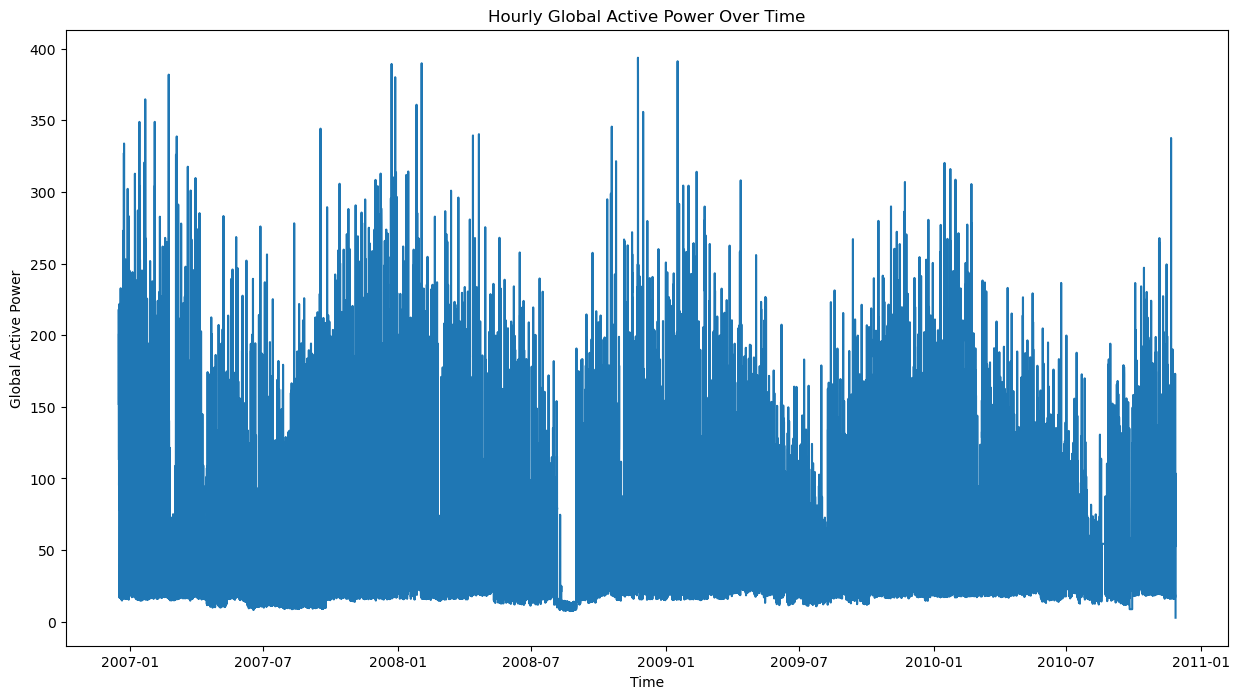

In [9]:

df = pd.DataFrame(household_data)
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
df.set_index('datetime', inplace=True)
df.drop(['Date', 'Time'], axis=1, inplace=True)

# Forward-fill missing values
df = df.ffill()

# Resample to hourly and sum over the minutes for each hour
df_hourly = df.resample('H').sum()

# Plot the hourly global_active_power over time
plt.figure(figsize=(15, 8))
plt.plot(df_hourly.index, df_hourly['Global_active_power'])
plt.title('Hourly Global Active Power Over Time')
plt.xlabel('Time')
plt.ylabel('Global Active Power')
plt.show()


#### The second plot is the plot of Hourly global active power over time

## Question 12

### What is the Pearson correlation coefficient between the global_active_power and voltage? To 3 decimal places

In [10]:

# Replace '?' with NaN in the specified columns
household_data['Global_active_power'] = pd.to_numeric(household_data['Global_active_power'], errors='coerce')
household_data['Voltage'] = pd.to_numeric(household_data['Voltage'], errors='coerce')

# Calculate the Pearson correlation coefficient
correlation_coefficient = household_data['Global_active_power'].corr(household_data['Voltage'])

correlation_coefficient_formatted = "{:.3f}".format(correlation_coefficient)
print(f"Pearson Correlation Coefficient: {correlation_coefficient_formatted}")





Pearson Correlation Coefficient: -0.400


## Question 13

### What is the Pearson correlation coefficient between the Voltage and global_intensity? To 2 decimal places.

In [11]:

correlation_coefficient = household_data['Voltage'].corr(household_data['Global_intensity'])

# Round to 2 decimal places
correlation_coefficient_rounded = round(correlation_coefficient, 2)

print(f"Pearson Correlation Coefficient: {correlation_coefficient_rounded}")


Pearson Correlation Coefficient: -0.41


### Using the daily sampling rate (sum), divide the data into a train and test set. The last 300 days is your test set and the first (x-300) days is your training set. Where x is the length of the dataset. Use Facebook Prophet to train a Univariate time series modeling using this time column (‘dt’ or ‘ds’) and the global_active_power (or ‘y’). Answer questions 14 - 16



## Question 14

### Evaluating the results of your time series modeling on the test set. What is the MAPE (in %) in 2 decimal places?

In [ ]:

# Reset the index to have 'ds' and 'y' columns for Prophet
df_prophet = df_resampled.reset_index()[['datetime', 'Global_active_power']]
df_prophet.columns = ['ds', 'y']

# Split the data into training and test sets
train_size = len(df_prophet) - 300
train_data = df_prophet.iloc[:train_size]
test_data = df_prophet.iloc[train_size:]

# Create and fit the Prophet model
model = Prophet()
model.fit(train_data)

# Make predictions on the test set
future = model.make_future_dataframe(periods=300, freq='D')
forecast = model.predict(future)

# Calculate MAPE
mape = mean_absolute_error(test_data['y'], forecast.iloc[-300:]['yhat']) / test_data['y'].mean() * 100

# Print the MAPE result to 2 decimal places
print(f"MAPE: {mape:.2f}%")


## Question 15

### What is the RMSE in 2 decimal places?

In [ ]:

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_actual, test_predicted))

# Print the RMSE result to 2 decimal places
print(f"RMSE: {rmse:.2f}")


## Question 16

### If you plot the components from the forecasted model, what day of the weekly seasonality has the lowest value?

## Multivariate Time Series Forecasting with Facebook Prophet



### In the last exercise, we used only the dependent variable (Global_Active_Power) and the time component for our modeling (ds vs y). Next, we will build a time series model using the other variables. These variables will be added to the forecast model as a regressor on Facebook Prophet. So the six independent variables ['Global_reactive_power', 'Voltage','Global_intensity', 'Sub_metering_1','Sub_metering_2','Sub_metering_3'] will be [‘add1’, ‘add2’, ‘add3’, ‘add4’, ‘add5’, ‘add6’] as the regressors. Split the data into train and test as done above and build a multivariate forecast model to forecast the last 300 days of the house consumption (‘global_active_power’). Answer questions 17-20:



## Question 17

### Evaluating the results of your time series modeling on the test set, what is the MAPE (in %) in 2 decimal places?

## Question 18

### What is the RMSE in 2 decimal places?

## Question 19

### If you plot the components from the multivariate forecasted model, what day of the daily seasonality has the lowest value?

In [17]:

model = Prophet(daily_seasonality=True, yearly_seasonality=False)
model.fit(df)
future = model.make_future_dataframe(periods=365)  # Adjust the periods as needed
forecast = model.predict(future)
fig = model.plot_components(forecast)

# Extract daily seasonality component
daily_seasonality = forecast['daily'].values

# Find the day with the lowest value
lowest_value_day = daily_seasonality.argmin()

# Print the result
print(f"The day with the lowest daily seasonality value is: {forecast['ds'].iloc[lowest_value_day].day_name()}")


NameError: name 'Prophet' is not defined

## Queation 20

### If you plot the components from the forecasted model, what month of the yearly seasonality has the lowest value?